In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [ ]:
path='/content/drive/MyDrive/Colab Notebooks/Data/MRI'
train_images=sorted(os.listdir(path))[0:500]

In [ ]:
SIZE=512
train_image=[]
for i in tqdm(train_images):
    img=cv2.imread(path+'/'+i,0)
    img=cv2.resize(img,(SIZE,SIZE))
    train_image.append(img_to_array(img))

100%|██████████| 500/500 [00:02<00:00, 179.18it/s]


In [ ]:
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(SIZE,SIZE), cmap='gray')
  plt.show()

In [ ]:
clean_train = np.reshape(train_image, (len(train_image), SIZE, SIZE, 1))
clean_train = clean_train.astype('float32') / 255
noised_df = clean_train + 0.2 * np.random.normal(loc=0.0, scale=1.0, size=clean_train.shape)

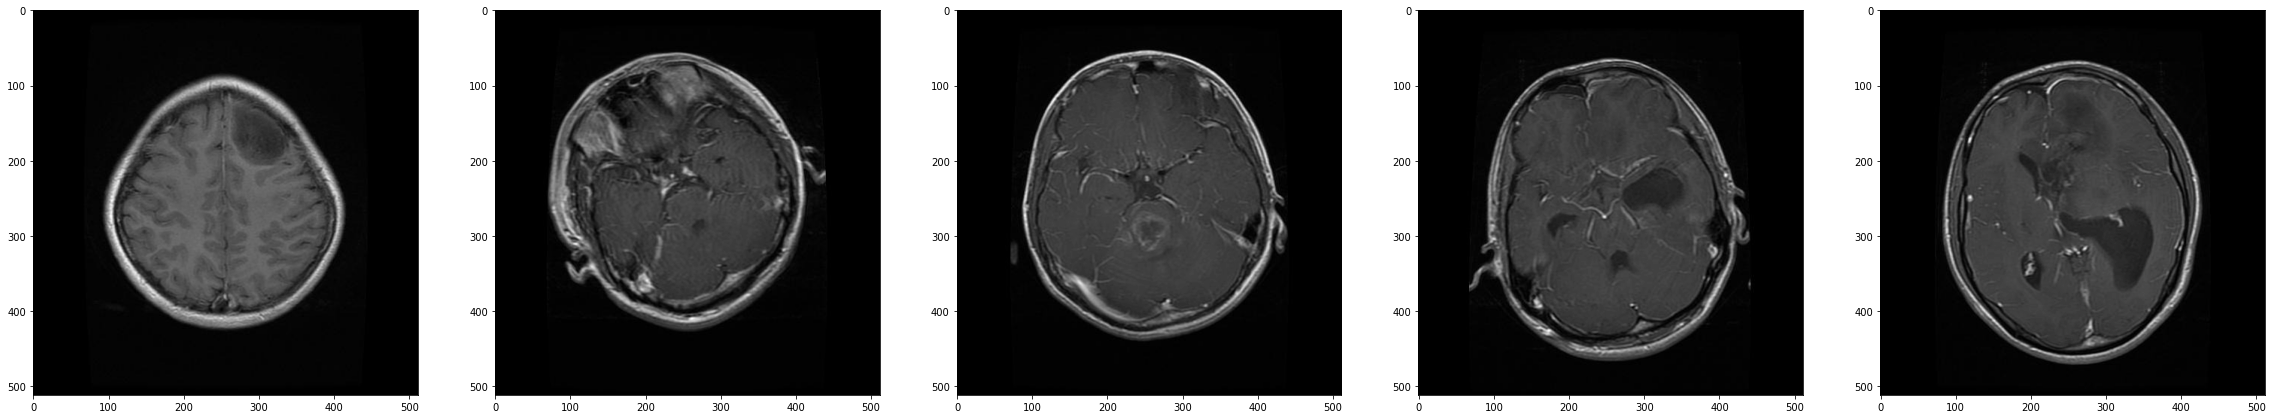

In [ ]:
plot_img(clean_train)

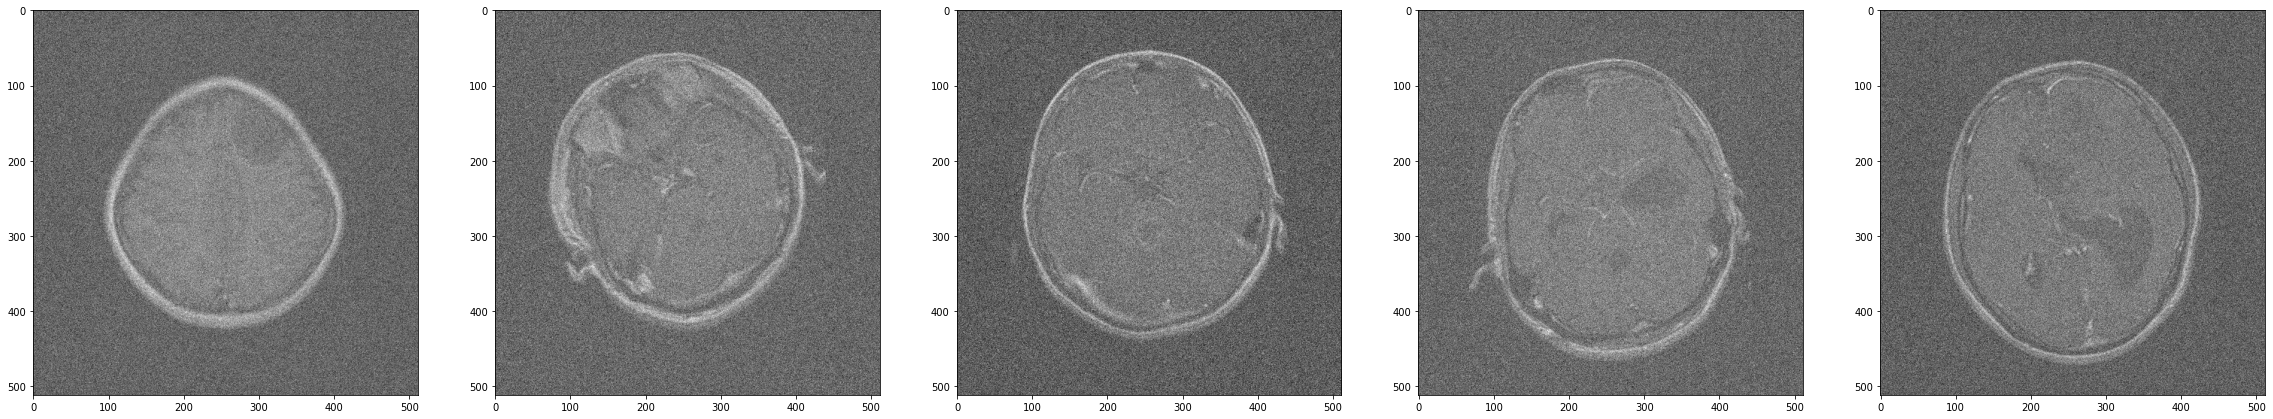

In [ ]:
plot_img(noised_df)

In [ ]:
def autoencoder():
  input_img=Input(shape=(SIZE,SIZE,1),name='image_input')
  #enoder
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(8, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same', name='Conv3')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool3')(x)

  #decoder
  x = Conv2D(8, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(8, (3,3), activation='relu', padding='same', name='Conv5')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv6')(x)
  x = UpSampling2D((2,2), name='upsample3')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv7')(x)

  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='mean_squared_error')

  return autoencoder

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(noised_df, clean_train, test_size = 0.20, random_state = 0)

In [ ]:
model= autoencoder()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 512, 512, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 512, 512, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 256, 256, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 256, 256, 8)       2312      
                                                                 
 pool2 (MaxPooling2D)        (None, 128, 128, 8)       0         
                                                                 
 Conv3 (Conv2D)              (None, 128, 128, 8)       584       
                                                                 
 pool3 (MaxPooling2D)        (None, 64, 64, 8)         0   

In [ ]:
model.fit(x_train, y_train, epochs=10, batch_size=10, shuffle=True, verbose = 1, validation_split = 0.1)

Epoch 1/10
36/36 [==============================] - 196s 5s/step - loss: 0.0723 - val_loss: 0.0199
Epoch 2/10
36/36 [==============================] - 201s 6s/step - loss: 0.0142 - val_loss: 0.0120
Epoch 3/10
36/36 [==============================] - 200s 6s/step - loss: 0.0093 - val_loss: 0.0080
Epoch 4/10
36/36 [==============================] - 194s 5s/step - loss: 0.0065 - val_loss: 0.0060
Epoch 5/10
36/36 [==============================] - 195s 5s/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/10
36/36 [==============================] - 195s 5s/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/10
36/36 [==============================] - 195s 5s/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/10
36/36 [==============================] - 194s 5s/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/10
36/36 [==============================] - 194s 5s/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/10
36/36 [==============================] - 195s 5s/step - loss: 0.0025 - val_loss: 0.0026


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Data/denoising.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Data/denoising.model/assets


In [ ]:
xtrain= clean_train[100:]

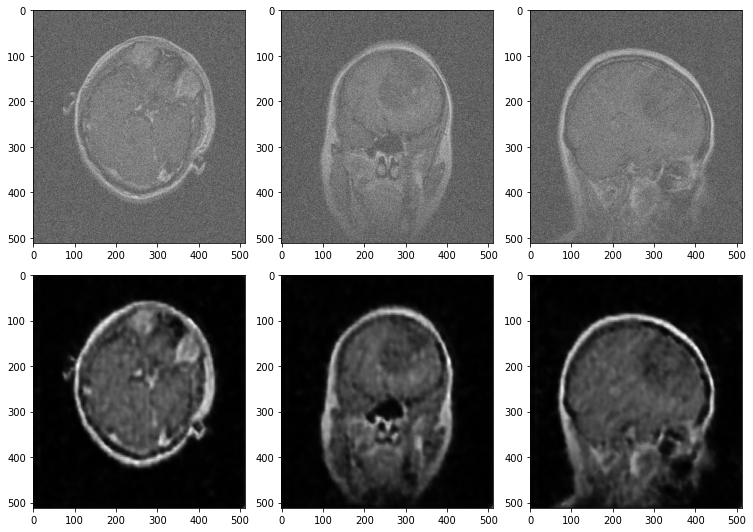

In [ ]:
pred= model.predict(x_test[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(2, 3)
    f.set_size_inches(10.5,7.5)
    for i in range(3):
        ax[0][i].imshow(np.reshape(y_true[i], (SIZE,SIZE)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_pred[i], (SIZE,SIZE)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(x_test[:5], pred[:5])

In [ ]:
def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
print(f"PSNR Value : {PSNR(x_test[0], pred[0])} dB")
print(f"SSIM Value : {calculate_ssim(x_test[0], pred[0])}")

PSNR Value : 61.927911998398166 dB
SSIM Value : 0.9990010785062736


In [ ]:
print(f"PSNR Value : {PSNR(x_test[3], pred[3])} dB")
print(f"SSIM Value : {calculate_ssim(x_test[3], pred[3])}")

PSNR Value : 61.91142385628493 dB
SSIM Value : 0.9989649027723934
